# Synthetic multi-fidelity GP.
helpful link for legend formatting: [here](https://stackoverflow.com/questions/21570007/subheadings-for-categories-within-matplotlib-custom-legend)

In [1]:
import math
import torch
from torch.optim import Adam
import gpytorch
from botorch import fit_gpytorch_model
from matplotlib import pyplot as plt
import seaborn as sns
from botorch.models import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim.fit import fit_gpytorch_torch # fix Cholecky jitter error


%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from botorch.acquisition.analytic import ExpectedImprovement
from torch.distributions import Normal


sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine(top=True, right=True)

/home/ng/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

In [2]:
#plt.rcParams["font.family"] = "JetBrains Mono"

In [3]:
pal = sns.color_palette('Set2')
pal

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

### The ground truth

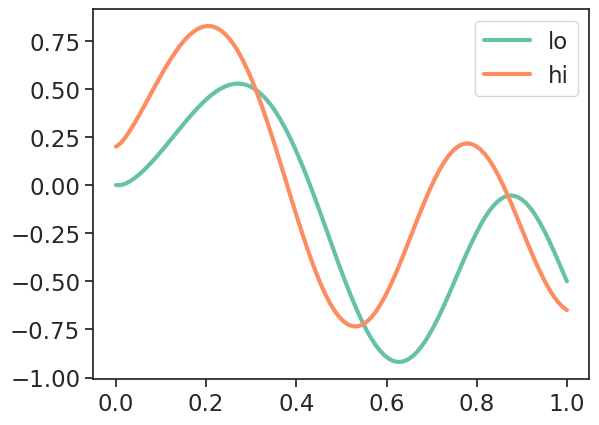

In [4]:
def f_true(x, l):
    # low-fidelity
    if l < 1/2:
        return - x / (1 + x ) + np.sin(3 * x **1.5 *math.pi)*np.exp(-x)
    # high-fidelity
    else:
        return - x / (1 + x ) + np.sin(3.4 * x **1.3 *math.pi)*np.exp(-x)+ 0.2
    
ground_x = torch.linspace(0, 1, 100)
ground_y_lo = f_true(ground_x, 1/3)
ground_y_hi = f_true(ground_x, 2/3)

plt.figure()
plt.plot(ground_x, ground_y_lo, label="lo")
plt.plot(ground_x, ground_y_hi, label="hi")
plt.legend()

## The data

In [5]:
# raw data. xs and fidelities
xs = [0.01, 0.2, 0.21, 0.6, 0.85, 0.98, 0.2, 0.6, 0.605]
ls = [1/3,  1/3, 1/3, 1/3, 1/3,  2/3, 2/3, 2/3, 2/3]

# turn into torch tensors
train_x = torch.tensor([[xs[i], ls[i]] for i in range(len(xs))], dtype=torch.float64)
train_y = torch.tensor([f_true(xs[i], ls[i]) for i in range(len(xs))]).unsqueeze(-1)

In [6]:
def filter_data_for_plotting(f):
    return [train_x[i][0].item() for i in range(train_x.size()[0]) if train_x[i][1] == f], [train_y[i][0].item() for i in range(train_x.size()[0]) if train_x[i][1] == f]

## The surrogate model

In [7]:
def train_surrogate_model(X_train, y_train):
    model = SingleTaskMultiFidelityGP(
        X_train, 
        y_train, 
        linear_truncated=False,
        outcome_transform=Standardize(m=1), # m is the output dimension
        data_fidelity=1
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll) # note, this is a bit different from in the code b/c I got an error.
    return model

In [8]:
# calculate posterior mean and variance for a given fidelity
def mu_sigma(model, x_r, fidelity):
    f = torch.tensor((), dtype=torch.float64).new_ones((x_r.size()[0], 1)) * fidelity
    X_f = torch.cat((x_r, f), dim=1) # last col is associated fidelity
    f_posterior = model.posterior(X_f)
    return f_posterior.mean.squeeze().detach().numpy(), np.sqrt(f_posterior.variance.squeeze().detach().numpy())

In [9]:
model = train_surrogate_model(train_x, train_y)

In [10]:
for n, v in model.named_parameters():
      print(n, v)

likelihood.noise_covar.raw_noise Parameter containing:
tensor([0.0007], dtype=torch.float64, requires_grad=True)
mean_module.raw_constant Parameter containing:
tensor(0.2367, dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(3.5503, dtype=torch.float64, requires_grad=True)
covar_module.base_kernel.kernels.0.raw_lengthscale Parameter containing:
tensor([[-1.6443]], dtype=torch.float64, requires_grad=True)
covar_module.base_kernel.kernels.1.raw_power Parameter containing:
tensor([-0.7847], dtype=torch.float64, requires_grad=True)
covar_module.base_kernel.kernels.1.raw_offset Parameter containing:
tensor([-0.8408], dtype=torch.float64, requires_grad=True)


## viz

In [11]:
colors = [pal[1], pal[4]]
markers = ["o", "s"]

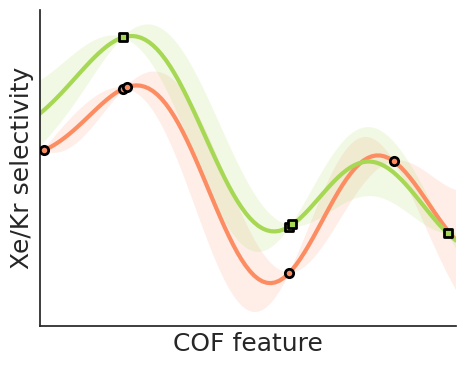

In [12]:
plt.figure(figsize=(5, 4))
# range of x's for plotting.
x_r = torch.tensor([[x_i] for x_i in np.linspace(0, 1, 100)], dtype=torch.float64)
for (f, label, color, marker) in zip([1/3, 2/3], ["low-fid.", "high-fid."], colors, markers):
    m, s = mu_sigma(model, x_r, f)
    plt.plot(x_r, m, label=label, color=color)
    
    lower = m - s
    upper = m + s
    plt.fill_between(x_r.squeeze(), lower, upper, 
                         alpha=0.15, color=color, edgecolor="none", zorder=f)
    
    x_data, y_data = filter_data_for_plotting(f)
    plt.scatter(x_data, y_data, marker=marker, color=color, edgecolor="black", linewidth=2, zorder=100)
# plt.xlabel("COF space, $\mathbf{x}$")
plt.xlabel("COF feature")
# plt.ylabel("Xe/Kr selectivity, $y^{(\ell)}$")
plt.ylabel("Xe/Kr selectivity")
plt.yticks([])
plt.xticks([])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([0, 1])
# plt.ylim([-1.2, 1.2])
plt.tight_layout()
# plt.legend()
plt.savefig("toy_multifidelity_gp.pdf", format="pdf")

## a single-fidelity GP

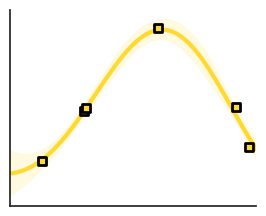

In [13]:
xs = [0.13, 0.3, 0.31, 0.6, 0.92, 0.97]

def f_true(x):
    return -(x ** 3 - x ** 2)

train_x = torch.tensor([[x, 1] for x in xs], dtype=torch.float64)
train_y = torch.tensor([f_true(xs[i]) for i in range(len(xs))], dtype=torch.float64).unsqueeze(-1)

model = train_surrogate_model(train_x, train_y)

plt.figure(figsize=(3, 2.5))
# range of x's for plotting.
x_r = torch.tensor([[x_i] for x_i in np.linspace(0, 1, 100)], dtype=torch.float64)

color = pal[5] #pal[4]
m, s = mu_sigma(model, x_r, 1.0)
plt.plot(x_r, m, label=label, color=color)

lower = m - s
upper = m + s
plt.fill_between(x_r.squeeze(), lower, upper, 
                     alpha=0.15, color=color, edgecolor="none", zorder=f)

plt.scatter(xs, train_y, marker=marker, color=color, edgecolor="black", linewidth=2, zorder=100)
# plt.xlabel("COF space, $\mathbf{x}$")
# plt.ylabel("Xe/Kr selectivity, $y^{(\ell)}$")
plt.yticks([])
plt.xticks([])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([0, 1])
# plt.ylim([-1.2, 1.2])
plt.tight_layout()
plt.savefig("toy_gp.pdf", format="pdf")